# Filters learned from natural scene

The natural scene data set we used is from Meyer et al. 2014,  and can be downladed from [here](https://pub.uni-bielefeld.de/record/2689637).

The method to get the contrast from luminance is also outlined [here](https://elifesciences.org/articles/47579) and [here](https://jov.arvojournals.org/article.aspx?articleid=2761144): contrast is locally computed based on first spatially blurring to match the spatial acceptance functions of fly photoreceptors, and then subtracting a local estimate of mean luminance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy  as sp
from scipy.linalg import sqrtm
# import scipy.io
# from scipy.linalg import fractional_matrix_power
import sys
sys.path.append('./utils')

import h5py
%matplotlib inline
import os


# plt.style.use("./nature.mplstyle")

In [2]:

# Change the following path to the location of the data on your machine
meyer_data_folder = '/Users/shawnqin/Documents/dropbox_simons/Projects/data/meyer2014_data/savedData/'

# raw and contrast
img_file = 'combinedFiltered2D.mat'

# filtered images
img_filtered_file = 'filteredScenes.mat'

# Open the MATLAB v7.3 file
with h5py.File(meyer_data_folder + img_file, 'r') as file:
    imgs = file['scenes'][:]
    contrast = file['finalContrast'][:]

# load the filtered images
with h5py.File(meyer_data_folder + img_filtered_file, 'r') as file:
    imgs_filtered = file['filteredScenes'][:]

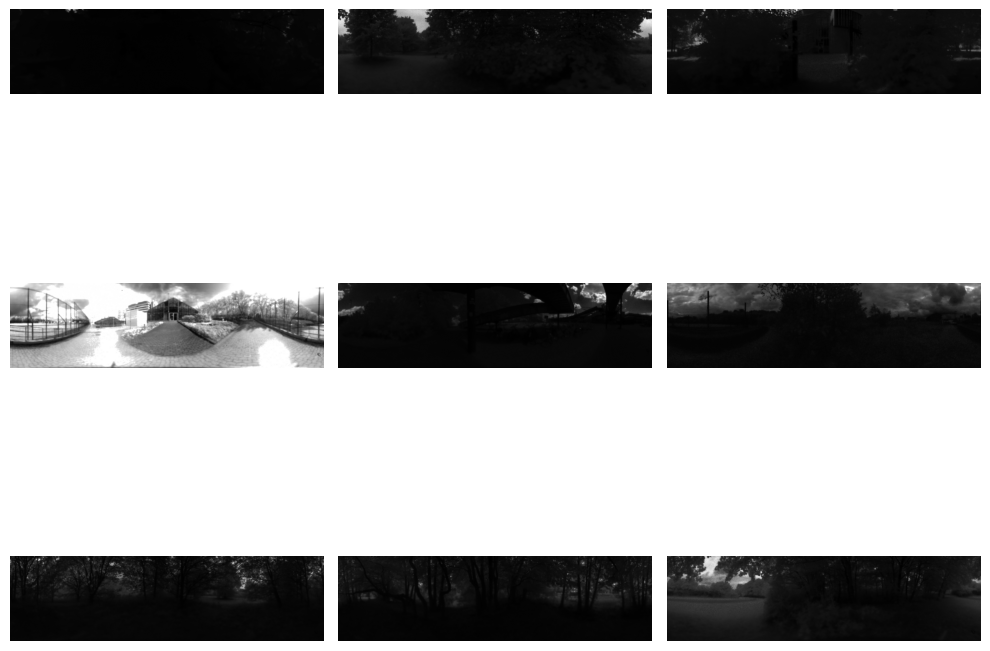

In [3]:
# randomly select 9 images to show
sel = np.random.randint(0,imgs.shape[0],9)
imgs_sel = imgs[sel,:,:]
contrast_sel = contrast[sel,:,:]
# imgs_filtered_sel = imgs_filtered[sel,:,:,:]
# imgs_sel.shap
# # make a 3 by 3 grid of the images
plt.close()
fig, ax = plt.subplots(3,3,figsize=(10,10))
for i in range(9):
    ax[i//3,i%3].imshow(imgs[sel[i],:,:].T, cmap='gray')
    ax[i//3,i%3].axis('off')
# tight layout
plt.tight_layout()
plt.show()  

In [4]:
row_sel = 30
contr_sel = contrast[:,:,row_sel].flatten()
contr_raw = contrast[:,:,row_sel]

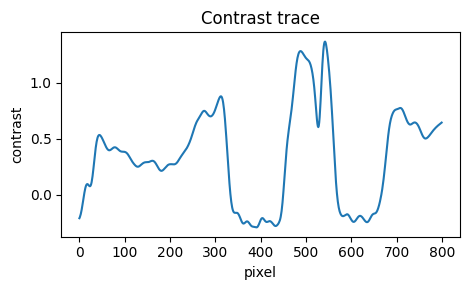

In [5]:
img_sel = 30
z = contrast[:,:,img_sel].flatten()
# plt.plot(z[-1000:])
# visualize the contrast
fig,ax = plt.subplots(figsize=(5,3))
plt.plot(z[-800:])
plt.xlabel('pixel')
plt.ylabel('contrast')
plt.title('Contrast trace')
plt.tight_layout()
plt.show()
# save the data as an illustration of the contrast trace
# if results folder does not exist, create it

if not os.path.exists('./results'):
    os.makedirs('./results')
np.save('./results/fig1_natural_scence_contrast_trace.npy', z[-800:])
np.save('./results/fig1_selected_scence.npy', contrast[img_sel])

In [6]:
# input is a slist of contrast
def past_future_multi(contrast, memory,horizon):
    lag = memory + horizon
    Ps = []
    Fs = []
    Q = 0
    Rp = 0 
    Rf = 0
    count = 0
    for contr_sel in contrast:
        H = sp.linalg.hankel(contr_sel[:lag],contr_sel[lag-1:])
        num_sample = H.shape[1]
        P = H[:memory,:]
        P = np.flipud(P)
        # Past.append(P)
        F = H[memory:,:]
        Q += F@P.T/num_sample
        Rp += P@P.T/num_sample
        Rf += F@F.T/num_sample
        # Qs.append(Q)
        Ps.append(P)
        Fs.append(F)
        count += 1
        # Compute SVD of partially whittened covariance
    # transform them into array
    P = np.hstack(Ps)
    F = np.hstack(Fs)
    Q = Q/count
    Rp = Rp/count
    Rf = Rf/count
    # Q = np.hstack(Qs)
    # Rp = P@P.T/P.shape[1]
    # Rf = F@F.T/F.shape[1]
    Rp_half = sqrtm(Rp)
    Rf_half = sqrtm(Rf)
    return Q, Rp_half, Rf_half,P,F

# CCA 
def cca_analysis(Q, Rp_half, Rf_half):
    # objective function
    W3 = np.linalg.inv(Rf_half)@Q@np.linalg.inv(Rp_half).T
    W3 = np.real(W3)
    U3, S3, Vh3 = sp.linalg.svd(W3,full_matrices=False)
    filter3 = Vh3@np.linalg.inv(Rp_half)
    return filter3

In [7]:
# subsample the contrast
degree_per_pixel = contrast.shape[1] / 360
sub_rate = 1
contr_sub = contr_sel[::sub_rate]
memory = 50
horizon = 50
noise_std = 0.05
# normalizaion and add noise
contr_sel_noise = (contr_sub - np.mean(contr_sub))/np.std(contr_sub) + noise_std*np.random.randn(contr_sub.shape[0])
# normalize each row of contr_raw
contr_raw_norm = (contr_raw - np.mean(contr_raw, axis=1, keepdims=True)) / np.std(contr_raw, axis=1, keepdims=True)
# add gaussian noise
contr_raw_noise = contr_raw_norm + noise_std * np.random.randn(contr_raw.shape[0], contr_raw.shape[1])
Q_train, Rp_half, Rf_half,P_train,F_train = past_future_multi(contr_raw_noise, memory,horizon)
# Explicit compute the objective function and its SVD
W3 = np.linalg.inv(Rf_half)@Q_train@np.linalg.inv(Rp_half).T
W3 = np.real(W3)
U3, S3, Vh3 = sp.linalg.svd(W3,full_matrices=False)
filter3 = Vh3@np.linalg.inv(Rp_half)


normalized_filters3 = filter3[:3, :] / np.max(np.abs(filter3[:3, :]), axis=1, keepdims=True)
# Plot the normalized filters


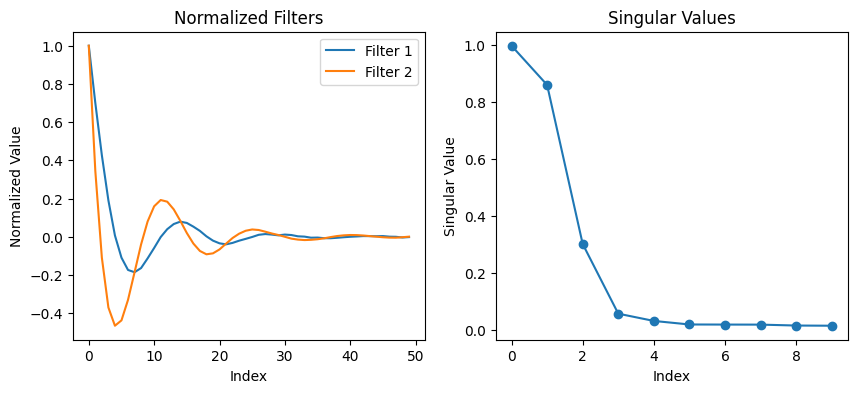

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
# plot the first 3 filters
for i in range(2):
    ax[0].plot(normalized_filters3[i, :], label=f'Filter {i+1}')
ax[0].set_title('Normalized Filters')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Normalized Value')    
ax[0].legend()
# plot the singular values
ax[1].plot(S3[:10], 'o-')        
ax[1].set_title('Singular Values')    
ax[1].set_xlabel('Index')    
ax[1].set_ylabel('Singular Value')    
plt.show()

In [9]:
# save the first 2 filters and the singular values
np.savez('./results/fig1_natural_scence_filters_sv.npz', filters = normalized_filters3[:2, :], singular_values=S3)
np.save('./results/fig2_singular_values.npy', S3)

## Noise-dependent effects

In [10]:
noise_levels =[0.005,0.05,0.5]
repeats = 10
filter_1st = {round(noise,3): [] for noise in noise_levels}
filter_2nd = {round(noise,3): [] for noise in noise_levels}
contr_raw_norm = (contr_raw - np.mean(contr_raw, axis=1, keepdims=True)) / np.std(contr_raw, axis=1, keepdims=True)

for noise in noise_levels:
    flt1 = []
    flt2 = []
    for i in range(repeats):
        contr_raw_noise = contr_raw_norm + noise * np.random.randn(contr_raw.shape[0], contr_raw.shape[1])

        Q_train, Rp_half, Rf_half,P_train,F_train = \
            past_future_multi(contr_raw_noise, memory,horizon)
        # Explicit compute the objective function and its SVD
        W3 = np.linalg.inv(Rf_half)@Q_train@np.linalg.inv(Rp_half).T
        W3 = np.real(W3)
        U3, S3, Vh3 = sp.linalg.svd(W3,full_matrices=False)
        filter3 = Vh3@np.linalg.inv(Rp_half)
        normalized_filters3 = filter3[:2, :] / np.max(np.abs(filter3[:2 :]),\
                                                    axis=1, keepdims=True)
        flt1.append(normalized_filters3[0, :])
        flt2.append(normalized_filters3[1, :])
        # filter_1st[round(noise,3)].append(normalized_filters3[0, :])
        # filter_2nd[round(noise,3)].append(normalized_filters3[1, :])
    filter_1st[round(noise,3)] = np.array(flt1)
    filter_2nd[round(noise,3)] = np.array(flt2)
# calculate the mean and std of the filters
filter_1st_mean = {round(noise,3): np.mean(flt1, axis=0) for noise, flt1 in filter_1st.items()}
filter_1st_std = {round(noise,3): np.std(flt1, axis=0) for noise, flt1 in filter_1st.items()}
filter_2nd_mean = {round(noise,3): np.mean(flt2, axis=0) for noise, flt2 in filter_2nd.items()}
filter_2nd_std = {round(noise,3): np.std(flt2, axis=0) for noise, flt2 in filter_2nd.items()}


In [11]:
# Generate up-down stairs trajectory, with up 3 steps and down 3 steps
def test_traj_step(num_steps=4,transient_length=100,plot=False):
    num_steps = 4
    # transient_length = 100
    test_traj = []
    slope = 1
    # slopes = 2*np.random.rand(num_transients) + 0.5
    xs = np.linspace(-10,10, transient_length)

    for i in range(num_steps):
        transient = np.tanh(xs/slope)/2 + 1 + (i+1)
        test_traj.append(transient)
    for i in range(num_steps):
        transient = -np.tanh(xs/slope)/2 + 1 + (num_steps-i)
        test_traj.append(transient)
    test_traj = np.concatenate(test_traj)

    # add noise to the trajectory
    noise_std = 0.0
    test_traj += noise_std*np.random.randn(len(test_traj))
    # plot the trajectory
    if plot:
        fig, ax = plt.subplots(figsize=(6, 1.5))
        plt.plot(test_traj,linewidth=1.5, color='k')
        plt.xlabel('Time')
        plt.ylabel('Intensity')
        # remove tickets of the axis
        ax.set_xticks([])
        ax.set_yticks([])

        # remove the box and axis
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
    return test_traj

In [12]:
test_traj =test_traj_step(transient_length=150)
noise_std = 0.01
test_traj_noise = test_traj + noise_std*np.random.randn(len(test_traj))
test_traj_log = np.log(test_traj_noise-1)
P_test = sp.linalg.hankel(test_traj_log[:memory], test_traj_log[memory-1:])

proj_L3 = filter_1st_mean[0.05]@P_test
proj_L2 = filter_2nd_mean[0.05]@P_test
proj_L1 = filter_2nd_mean[0.5]@P_test

In [13]:
# save the data for plotting
import pickle
with open('./results/fig3_natural_scence_filters.pkl', 'wb') as f:
    pickle.dump(filter_1st_mean, f)
    pickle.dump(filter_1st_std, f)
    pickle.dump(filter_2nd_mean, f)
    pickle.dump(filter_2nd_std, f)
    pickle.dump(proj_L1, f)
    pickle.dump(proj_L2, f)
    pickle.dump(proj_L3, f)
    pickle.dump(test_traj, f)
    pickle.dump(test_traj_noise, f)

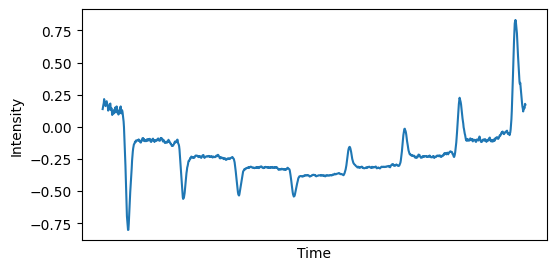

In [14]:
test_traj =test_traj_step(transient_length=150)
# add noise to the test trajectory
noise_std = 0.01
test_traj += noise_std*np.random.randn(len(test_traj))


lag = memory + horizon
test_traj_log = np.log(test_traj-1)
P_test = sp.linalg.hankel(test_traj_log[:memory], test_traj_log[memory-1:])

# projection of the first and 2nd filter
proj = filter3[:2,:]@P_test

# plot the projection
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(proj[1,:].T,linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Intensity')
# remove tickets of the axis
ax.set_xticks([])
# ax.set_yticks([])
plt.show()
